In [12]:
import pandas as pd

pd.set_option("display.max_columns", None)

import cufflinks as cf

# We set the all charts as public
cf.set_config_file(sharing="public", theme="pearl", offline=False)
cf.go_offline()

In [13]:
# read data
price_df = pd.read_csv("./data/forecasting.csv")
price_df.columns = price_df.columns.str.lower()
price_df["date"] = pd.to_datetime(price_df["date"])
len(price_df)

43544

## Feature Engineering

In [14]:
# extract features

price_df["is_apartment"] = (
    price_df["categories"].map(lambda x: "APARTMENT" in x).map(int)
)
price_df["categories"] = price_df["categories"].str.replace("APARTMENT, ", "")

price_df["is_duplex"] = price_df["categories"].map(lambda x: "DUPLEX" in x).map(int)
price_df["categories"] = price_df["categories"].str.replace("DUPLEX, ", "")


price_df["is_house"] = price_df["categories"].map(lambda x: "HOUSE" in x).map(int)
price_df["categories"] = price_df["categories"].str.replace("HOUSE, ", "")

# categorize space sizes
d = {range(0, 50): "sm", range(50, 100): "md", range(100, 2000): "bg"}

price_df["size"] = price_df["space"].apply(
    lambda x: next((v for k, v in d.items() if x in k), "sm")
)

# categorize with ChatGPT
residential = [
    "DUPLEX",
    "FURNISHED_FLAT",
    "APARTMENT",
    "FLAT",
    "ROOF_FLAT",
    "ATTIC_FLAT",
    "LOFT",
    "SINGLE_ROOM",
    "STUDIO",
    "HOUSE",
    "ROW_HOUSE",
    "DUPLEX, MAISONETTE",
    "HOUSE, SINGLE_HOUSE",
    "ROW_HOUSE",
    "ATTIC",
    "BIFAMILIAR_HOUSE",
    "HOUSE, BIFAMILIAR_HOUSE",
    "TERRACE_FLAT",
    "BACHELOR_FLAT",
    "HOUSE, VILLA",
    "HOUSE, MULTIPLE_DWELLING",
    "VILLA",
]

commercial = [
    "OFFICE",
    "COMMERCIAL",
    "RETAIL, PRACTICE",
    "SHOP, ATELIER",
    "RETAIL, COMMERCIAL",
    "RESTAURANT",
    "WORKSHOP",
    "RETAIL, SHOP",
    "SHOP",
    "RESIDENTIAL_COMMERCIAL_BUILDING",
    "HOBBY_ROOM",
    "INDUSTRIAL_OBJECT",
    "STORAGE_ROOM",
    "ATELIER",
    "CAFE_BAR, RESTAURANT",
    "RETAIL, HAIRDRESSER",
    "RETAIL_SPACE, ATELIER",
    "ADVERTISING_AREA",
    "FACTORY",
    "RETAIL, STORAGE_ROOM",
    "UNDERGROUND_SLOT",
    "CAFE_BAR, BAR",
    "PRACTICE",
    "COFFEEHOUSE",
]

price_df["is_residential"] = price_df["categories"].isin(residential).map(int).fillna(0)
price_df["is_commercial"] = price_df["categories"].isin(commercial).map(int).fillna(0)

In [25]:
# remove NAs in target
print(price_df.price.isna().value_counts())
print(price_df.space.isna().value_counts())

price_df = price_df.dropna(subset=["price", "space"])

# remove outliers
price_df = price_df[price_df.eval("price/space") < 90]
len(price_df)

False    30805
Name: price, dtype: int64
False    30805
Name: space, dtype: int64


30761

In [26]:
price_df.drop(columns=["date", "categories"]).corr().style.background_gradient(
    cmap="coolwarm"
)

,price,space,is_apartment,is_duplex,is_house,is_residential,is_commercial
price,1.000000,0.818750,-0.260752,0.171670,0.253495,-0.209745,0.110703
space,0.818750,1.000000,-0.187960,0.247368,0.270653,-0.265228,0.155516
is_apartment,-0.260752,-0.187960,1.000000,-0.268149,-0.295760,0.300939,-0.274301
is_duplex,0.171670,0.247368,-0.268149,1.000000,-0.023956,-0.102629,-0.022218
is_house,0.253495,0.270653,-0.295760,-0.023956,1.000000,-0.357388,-0.010500
is_residential,-0.209745,-0.265228,0.300939,-0.102629,-0.357388,1.000000,-0.730216
is_commercial,0.110703,0.155516,-0.274301,-0.022218,-0.010500,-0.730216,1.000000


In [27]:
residential_df = price_df.query("is_residential == 1").drop(
    columns=["is_commercial", "is_residential"]
)
len(residential_df)

30078

In [28]:
residential_df.sort_values("is_apartment")

,date,price,space,categories,is_apartment,is_duplex,is_house,size
0,2018-04-07,2650.0,190.0,DUPLEX,0,1,0,bg
14975,2019-07-15,2300.0,106.0,LOFT,0,0,0,bg
14980,2019-04-12,2300.0,106.0,LOFT,0,0,0,bg
38938,2019-10-25,2500.0,176.0,ROOF_FLAT,0,0,0,bg
30384,2018-08-31,2850.0,70.0,FURNISHED_FLAT,0,0,0,md
...,...,...,...,...,...,...,...,...
15018,2019-04-30,3800.0,164.0,APARTMENT,1,0,0,bg
15017,2021-08-11,940.0,24.0,FLAT,1,0,0,sm
15016,2019-12-05,2250.0,82.0,APARTMENT,1,0,0,md
15031,2019-02-01,1485.0,84.0,APARTMENT,1,0,0,md


In [29]:
residential_df.join(pd.get_dummies(residential_df["categories"]).applymap(int)).drop(
    columns=["date", "categories"]
).corr().style.background_gradient(cmap="coolwarm")

,price,space,is_apartment,is_duplex,is_house,APARTMENT,ATTIC,ATTIC_FLAT,BACHELOR_FLAT,BIFAMILIAR_HOUSE,DUPLEX,FLAT,FURNISHED_FLAT,LOFT,ROOF_FLAT,ROW_HOUSE,SINGLE_ROOM,STUDIO,TERRACE_FLAT,VILLA
price,1.000000,0.792546,-0.240276,0.196302,0.196900,-0.130956,-0.069157,0.101575,-0.001015,0.107344,0.196302,-0.148167,0.306969,0.032875,0.043559,0.161225,-0.139220,-0.072907,0.012549,0.100057
space,0.792546,1.000000,-0.130502,0.287969,0.202945,-0.048847,-0.080010,0.076990,-0.004337,0.131835,0.287969,-0.068746,0.010316,0.048733,0.078495,0.155572,-0.225249,-0.128584,0.012529,0.094671
is_apartment,-0.240276,-0.130502,1.000000,-0.317878,-0.233426,0.305530,-0.068065,-0.139695,-0.013242,-0.111149,-0.317878,0.295280,-0.373159,-0.087702,-0.240488,-0.203734,-0.181241,-0.123594,-0.030329,-0.051086
is_duplex,0.196302,0.287969,-0.317878,1.000000,-0.016931,-0.158088,-0.009357,-0.022290,-0.002234,-0.008062,1.000000,-0.152784,-0.060279,-0.014212,-0.037459,-0.014777,-0.025896,-0.018609,-0.005698,-0.003705
is_house,0.196900,0.202945,-0.233426,-0.016931,1.000000,-0.071319,-0.004221,-0.010056,-0.001008,0.476165,-0.016931,-0.068926,-0.027194,-0.006411,-0.016899,0.872800,-0.011682,-0.008395,-0.002571,0.038424
APARTMENT,-0.130956,-0.048847,0.305530,-0.158088,-0.071319,1.000000,-0.039413,-0.093893,-0.009411,-0.033959,-0.158088,-0.643570,-0.253912,-0.059863,-0.157786,-0.062247,-0.109080,-0.078387,-0.024003,-0.015608
ATTIC,-0.069157,-0.080010,-0.068065,-0.009357,-0.004221,-0.039413,1.000000,-0.005557,-0.000557,-0.002010,-0.009357,-0.038091,-0.015028,-0.003543,-0.009339,-0.003684,-0.006456,-0.004639,-0.001421,-0.000924
ATTIC_FLAT,0.101575,0.076990,-0.139695,-0.022290,-0.010056,-0.093893,-0.005557,1.000000,-0.001327,-0.004788,-0.022290,-0.090744,-0.035802,-0.008441,-0.022248,-0.008777,-0.015380,-0.011053,-0.003384,-0.002201
BACHELOR_FLAT,-0.001015,-0.004337,-0.013242,-0.002234,-0.001008,-0.009411,-0.000557,-0.001327,1.000000,-0.000480,-0.002234,-0.009095,-0.003588,-0.000846,-0.002230,-0.000880,-0.001542,-0.001108,-0.000339,-0.000221
BIFAMILIAR_HOUSE,0.107344,0.131835,-0.111149,-0.008062,0.476165,-0.033959,-0.002010,-0.004788,-0.000480,1.000000,-0.008062,-0.032820,-0.012949,-0.003053,-0.008047,-0.003174,-0.005563,-0.003998,-0.001224,-0.000796


In [30]:
residential_df

,date,price,space,categories,is_apartment,is_duplex,is_house,size
0,2018-04-07,2650.0,190.0,DUPLEX,0,1,0,bg
1,2018-03-15,2850.0,190.0,DUPLEX,0,1,0,bg
2,2020-06-05,4600.0,170.0,FURNISHED_FLAT,1,0,0,bg
10,2019-12-19,1270.0,65.0,APARTMENT,1,0,0,md
13,2018-06-25,1200.0,62.0,APARTMENT,1,0,0,md
...,...,...,...,...,...,...,...,...
43536,2020-08-12,2190.0,97.0,FLAT,1,0,0,md
43537,2021-02-04,1320.0,75.0,FLAT,1,0,0,md
43538,2020-08-10,1950.0,120.0,LOFT,1,0,0,bg
43539,2020-08-14,1990.0,70.0,DUPLEX,1,1,0,md


In [31]:
residential_df.eval("price/space").iplot(kind="hist")

## Modelling

In [32]:
from pycaret.regression import RegressionExperiment

s = RegressionExperiment()
s.setup(
    residential_df.drop(columns=["date", "categories"]),
    target="price",
    session_id=123,
    log_experiment=True,
    experiment_name="price_forecast",
)

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(30078, 6)"
4,Transformed data shape,"(30078, 8)"
5,Transformed train set shape,"(21054, 8)"
6,Transformed test set shape,"(9024, 8)"
7,Numeric features,4
8,Categorical features,1
9,Preprocess,True


run `mlflow ui` in the terminal

In [33]:
best = s.compare_models(
    include=[
        "lr",
        "ridge",
        "lasso",
        "huber",
        "rf",
        "catboost",
        "lightgbm",
        "knn",
        "xgboost",
    ]
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,283.0039,218334.9602,466.6763,0.7044,0.2413,0.1843,0.4790
rf,Random Forest Regressor,281.6775,218805.9972,467.2436,0.7035,0.2414,0.1836,0.0910
xgboost,Extreme Gradient Boosting,282.0528,219153.9234,467.5825,0.7031,0.2411,0.1836,0.0280
lightgbm,Light Gradient Boosting Machine,284.7293,219781.6858,468.2857,0.7024,0.2426,0.1858,0.4170
knn,K Neighbors Regressor,311.1644,252309.1078,501.9097,0.6579,0.2606,0.2030,0.0150
lr,Linear Regression,306.4545,254559.3553,503.7598,0.6562,0.2629,0.2009,0.2130
ridge,Ridge Regression,306.4424,254556.9204,503.7570,0.6562,0.2629,0.2008,0.0120
lasso,Lasso Regression,306.3493,254620.4439,503.8078,0.6561,0.2621,0.2005,0.0150
huber,Huber Regressor,297.7530,262301.7136,511.2317,0.6461,0.2581,0.1876,0.0460


In [34]:
print(best)

In [35]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [37]:
mdl = s.create_model("catboost")
tuned_model = s.tune_model(mdl, optimize="RMSE", search_library="scikit-optimize")
s.evaluate_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,281.5945,213919.2485,462.5141,0.7256,0.2438,0.1840
1,277.7936,193141.4226,439.4786,0.6901,0.2374,0.1812
2,287.2177,255317.9065,505.2899,0.6471,0.2475,0.1857
3,274.5593,196096.9662,442.8284,0.7194,0.2358,0.1828
4,289.2543,239317.3336,489.2007,0.7027,0.2672,0.2101
5,278.4573,214557.9738,463.2040,0.7242,0.2379,0.1821
6,287.1741,254666.5541,504.6450,0.7057,0.2282,0.1701
7,284.0634,199868.8965,447.0670,0.7188,0.2367,0.1808
8,278.9417,201694.0912,449.1037,0.7034,0.2395,0.1815


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,301.6859,241441.7455,491.3672,0.6903,0.2605,0.1980
1,294.9767,206968.1832,454.9376,0.6679,0.2500,0.1949
2,303.8107,269395.4549,519.0332,0.6276,0.2588,0.1986
3,294.0437,220869.2947,469.9673,0.6839,0.2524,0.1976
4,314.9275,273312.9903,522.7934,0.6605,0.2812,0.2267
5,296.8138,244858.9149,494.8322,0.6853,0.2562,0.1971
6,306.9258,285784.9031,534.5885,0.6697,0.2416,0.1828
7,301.2267,220234.5876,469.2916,0.6901,0.2504,0.1953
8,293.6193,208939.3646,457.0989,0.6927,0.2525,0.1964


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

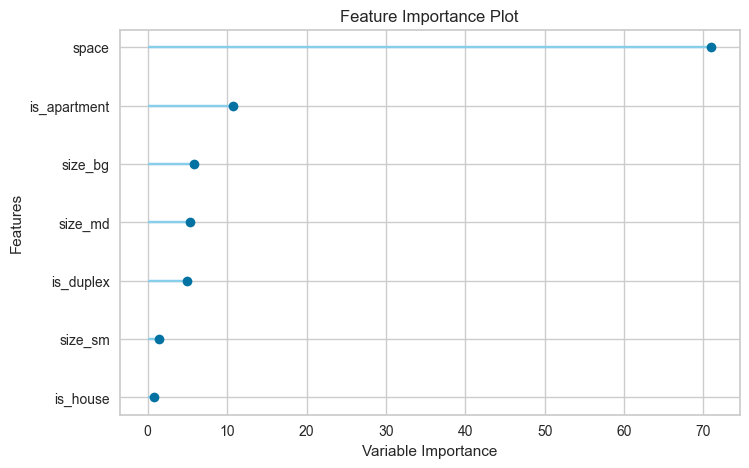

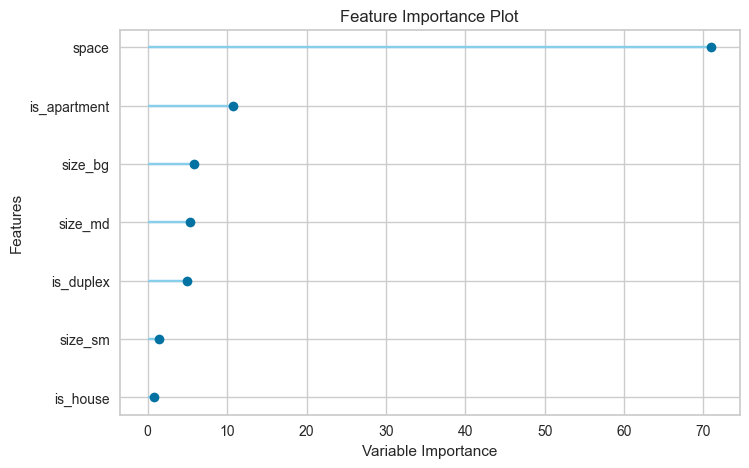

In [49]:
s.plot_model(best, plot="feature")
s.plot_model(tuned_model, plot="feature")

In [50]:
s.predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,282.5492,211388.1359,459.7697,0.7120,0.2529,0.2325


,space,is_apartment,is_duplex,is_house,size,price,prediction_label
29486,123.0,1,0,0,bg,2650.0,2619.261685
4444,70.0,1,0,0,md,1250.0,1654.055849
42627,110.0,1,0,0,bg,3000.0,2299.280280
20557,70.0,1,0,0,md,1340.0,1654.055849
8643,89.0,1,0,0,md,2595.0,1807.374057
...,...,...,...,...,...,...,...
12884,55.0,1,0,0,md,1200.0,1220.138261
1311,48.0,1,0,0,sm,1600.0,1071.569620
15879,60.0,1,0,0,md,1230.0,1225.810664
29457,123.0,1,0,0,bg,2600.0,2619.261685


In [51]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,282.5492,211388.1359,459.7697,0.7120,0.2529,0.2325


,space,is_apartment,is_duplex,is_house,size,price,prediction_label
29486,123.0,1,0,0,bg,2650.0,2619.261685
4444,70.0,1,0,0,md,1250.0,1654.055849
42627,110.0,1,0,0,bg,3000.0,2299.280280
20557,70.0,1,0,0,md,1340.0,1654.055849
8643,89.0,1,0,0,md,2595.0,1807.374057
...,...,...,...,...,...,...,...
12884,55.0,1,0,0,md,1200.0,1220.138261
1311,48.0,1,0,0,sm,1600.0,1071.569620
15879,60.0,1,0,0,md,1230.0,1225.810664
29457,123.0,1,0,0,bg,2600.0,2619.261685


## Model Price per square meter

In [52]:
ts_df = residential_df.dropna(subset=["space"]).reset_index(drop=True)
ts_df["price_sqm"] = ts_df.eval("price/space").map(lambda x: int(x * 100) / 100)
ts_df = ts_df.join(pd.get_dummies(ts_df["categories"]).applymap(int))
ts_df.shape

(30078, 24)

In [56]:
ts_df.set_index("date")["price_sqm"].resample("M").mean().iplot()

In [60]:
from pycaret.regression import RegressionExperiment

s = RegressionExperiment()
s.setup(
    ts_df.drop(columns=["date", "space", "price"]),  # drop space and date
    target="price_sqm",
    session_id=123,
    log_experiment=True,
    experiment_name="price_sqm_forecast",
)

,Description,Value
0,Session id,123
1,Target,price_sqm
2,Target type,Regression
3,Original data shape,"(30078, 21)"
4,Transformed data shape,"(30078, 37)"
5,Transformed train set shape,"(21054, 37)"
6,Transformed test set shape,"(9024, 37)"
7,Numeric features,18
8,Categorical features,2
9,Preprocess,True


In [61]:
best = s.compare_models(
    include=[
        "lr",
        "ridge",
        "lasso",
        "huber",
        "rf",
        "catboost",
        "lightgbm",
        "knn",
        "xgboost",
    ]
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,3.8177,34.5778,5.8751,0.4509,0.2254,0.1810,0.3770
rf,Random Forest Regressor,3.8172,34.5819,5.8754,0.4508,0.2254,0.1810,0.1830
xgboost,Extreme Gradient Boosting,3.8178,34.5818,5.8754,0.4508,0.2254,0.1810,0.0430
lightgbm,Light Gradient Boosting Machine,3.8210,34.6615,5.8822,0.4496,0.2257,0.1812,0.4110
lr,Linear Regression,3.8643,35.2465,5.9318,0.4402,0.2274,0.1833,0.2160
ridge,Ridge Regression,3.8604,35.2492,5.9320,0.4402,0.2274,0.1832,0.0240
huber,Huber Regressor,3.8041,35.6800,5.9676,0.4336,0.2269,0.1777,0.0940
knn,K Neighbors Regressor,4.2168,40.1234,6.3318,0.3608,0.2424,0.1961,0.0520
lasso,Lasso Regression,5.1335,61.4849,7.8301,0.0263,0.2811,0.2304,0.0340


In [62]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…